<a href="https://colab.research.google.com/github/DarShabi/OCR-Project/blob/main/Screening_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installs and Imports  


In [1]:
!pip install -q ImageHash;
!apt-get install -q tesseract-ocr;
!pip install -q pytesseract;
!pip install -q requests;
!pip install -q transformers;

Reading package lists...
Building dependency tree...
Reading state information...
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.


In [2]:
from PIL import Image
from PIL import ImageEnhance, ImageOps
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import requests
import glob
import json
from collections import Counter, defaultdict
import re
import matplotlib.image as mpimg
import seaborn as sns
import cv2
import imagehash
import pytesseract
from sklearn.model_selection import train_test_split
import cv2
import re
import urllib.request
import time
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import itertools

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Laoding the data

In [4]:
# Define the paths to the saved CSV files
train_path = '/content/drive/MyDrive/OCR_Project/train.csv'
val_path = '/content/drive/MyDrive/OCR_Project/val.csv'
test_path = '/content/drive/MyDrive/OCR_Project/test.csv'
na_data_path = '/content/drive/MyDrive/OCR_Project/N_A_images.csv'

In [5]:
# Read the datasets into DataFrames
train_df = pd.read_csv(train_path)
val_df = pd.read_csv(val_path)
test_df = pd.read_csv(test_path)
NA_df = pd.read_csv(na_data_path)

# Building the pipeline:

## Dealing with images the matches the images from N/A_df

In [6]:
def fill_text_nulls(df, text='NO TEXT'):
    """
    Fills the null values in the 'text' column of the given DataFrame with the string "NO TEXT".

    Parameters:
    - df: The input DataFrame.

    Returns:
    - DataFrame: The DataFrame with null values in the 'text' column filled.
    """
    df['text'].fillna(text, inplace=True)
    return df

In [7]:
def match_hashes_with_precomputed(df, na_df):
    """
    Matches the images in the given DataFrame with the precomputed hashes in na_df
    and sets the 'prediction' and 'text' accordingly.

    Parameters:
    - df: DataFrame containing file paths to the images.
    - na_df: DataFrame with precomputed hashes and associated texts.

    Returns:
    - DataFrame: The updated DataFrame with 'prediction' and 'text' set based on hash matches.
    """
    hash_to_text = dict(zip(na_df['hash'], na_df['text']))

    for index, row in df.iterrows():
        image_path = row['file_path']
        with Image.open(image_path) as img:
            if img.mode == 'P':
                img = img.convert('RGBA')
            h = str(imagehash.dhash(img))
            if h in hash_to_text:
                df.at[index, 'prediction'] = hash_to_text[h]
                df.at[index, 'text'] = hash_to_text[h]  # Setting the 'text' column
            else:
                df.at[index, 'prediction'] = 'TBD'
    return df


## Dealing with one-color images

In [8]:
def is_one_color_image(image_path):
    """
    Determines if a given image consists of a single color.

    Parameters:
    - image_path (str): Path to the image file.

    Returns:
    - bool: True if the image consists of a single color, False otherwise.
    """
    with Image.open(image_path) as img:
        if img.mode == 'P':
            img = img.convert('RGBA')
        image = img.convert("RGB")

    pixels = np.array(image)
    first_pixel = pixels[0, 0]

    return (pixels == first_pixel).all()


def handle_one_color_images(df, text='NO TEXT'):
    """
    Identifies and handles one-color images in the given DataFrame.

    Parameters:
    - df (DataFrame): A DataFrame containing file paths to the images.

    Returns:
    - DataFrame: Updated DataFrame with 'prediction' set to the given text for one-color images.
    """
    for index, row in df.iterrows():
        # Only process if prediction is 'TBD'
        if row['prediction'] == 'TBD':
            image_path = row['file_path']
            if is_one_color_image(image_path):
                df.at[index, 'prediction'] = text
    return df

## Dealing with no-text images explicitly

In [9]:
def tesseract_text_recognition(df, text_threshold=8, text='NO TEXT'):
    """
    Recognizes text from images in the given DataFrame using Tesseract. If the recognized text is below a threshold,
    the function sets the 'prediction' for that image to the given text.

    Parameters:
    - df (DataFrame): A DataFrame containing file paths to the images.
    - text_threshold (int): The minimum number of characters for an image to not be considered as having "NO TEXT".
    - text (str): The prediction text to set for images with minimal recognized text.

    Returns:
    - DataFrame: Updated DataFrame with 'prediction' set based on recognized text.
    """

    def enhanced_ocr(image_path):
        """
        Pre-process and recognize text from an image using Tesseract with enhanced configurations.
        """
        # Pre-processing
        img = Image.open(image_path)
        if img.mode == 'P':
            img = img.convert('RGBA')
        img = img.convert("L")  # Convert to grayscale
        img = ImageOps.autocontrast(img)           # Improve contrast
        enhancer = ImageEnhance.Sharpness(img)
        img = enhancer.enhance(2)                  # Sharpen the image

        # Try OCR
        text = pytesseract.image_to_string(img, config='--psm 11')
        return text

    for index, row in df.iterrows():
        # Only process if prediction is 'TBD'
        if row['prediction'] == 'TBD':
            image_path = row['file_path']
            recognized_text = enhanced_ocr(image_path)

            if len(recognized_text) < text_threshold:
                df.at[index, 'prediction'] = text
            else:
                df.at[index, 'prediction'] = 'TBD'
    return df

## Evaluation

**True Positive (TP):** Images correctly identified to continue to OCR.  
Condition:
$$\text{text} \neq \text{'NO TEXT'}$$
$$\text{AND}$$
$$\text{prediction} = \text{'TBD'}$$

**False Positive (FP):** Images incorrectly identified to continue to OCR.  
Condition:
$$\text{text} \neq \text{'NO TEXT'}$$
$$\text{AND}$$
$$\text{prediction} \neq \text{'TBD'}$$

**True Negative (TN):** Images correctly identified to not continue to OCR.  
Condition:
$$\text{text} = \text{prediction}$$

**False Negative (FN):** Images incorrectly identified to not continue to OCR.  
Condition:
$$\text{text} \neq \text{prediction}$$
$$\text{AND}$$
$$\text{prediction} = \text{'NO TEXT'}$$



In [10]:
def calculate_metrics(df):
    """
    Calculate the performance metrics based on the given DataFrame.

    Parameters:
    - df (DataFrame): The DataFrame containing true labels and predictions.

    Returns:
    - TP, TN, FP, FN, precision, recall, accuracy, f1
    """
    TP = len(df[(df['prediction'] == 'NO TEXT') & (df['text'] == 'NO TEXT')])
    TN = len(df[(df['prediction'] == 'TBD') & (df['text'] != 'NO TEXT')])
    FN = len(df[(df['prediction'] == 'NO TEXT') & (df['text'] != 'NO TEXT')])
    FP = len(df[(df['prediction'] != 'NO TEXT') & (df['text'] == 'NO TEXT')])

    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    f1 = 2 * (precision * recall) / (precision + recall)

    return TP, TN, FP, FN, precision, recall, accuracy, f1

def plot_confusion_matrix(df):
    """
    Plot the confusion matrix based on the given DataFrame.

    Parameters:
    - df (DataFrame): The DataFrame containing true labels and predictions.
    """
    TP, TN, FP, FN, precision, recall, accuracy, f1 = calculate_metrics(df)
    cm = np.array([[TP, FP], [FN, TN]])

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ["Predicted No OCR", "Predicted OCR"], rotation=45)
    plt.yticks(tick_marks, ["Actual No OCR", "Actual OCR"])

    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    # Calculate the percentages
    total_images = TP + TN + FP + FN
    percentage_screened_out = (TP / total_images) * 100
    percentage_mistakes = (FN / total_images) * 100


    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Percentage of Correctly Screened Out Images: {percentage_screened_out:.2f}%")
    print(f"Percentage of Mistakes (False Negatives): {percentage_mistakes:.2f}%")


# PIPELINE

In [11]:
class OCRPipeline:
    def __init__(self, data, na_df):
        self.data = data
        if 'prediction' not in self.data.columns:
          self.data['prediction'] = 'TBD'
        self.na_df = na_df
        self.screened_out_counts = {
            'initial': len(data[data['prediction'] == 'TBD']),
            'after_hashes': None,
            'after_one_color': None,
            'after_tesseract': None
        }

    def fill_text_nulls(self):
        self.data = fill_text_nulls(self.data)

    def match_hashes(self):
        self.data = match_hashes_with_precomputed(self.data, self.na_df)
        self.screened_out_counts['after_hashes'] = len(self.data[self.data['prediction'] == 'TBD'])

    def handle_one_color(self):
        self.data = handle_one_color_images(self.data)
        self.screened_out_counts['after_one_color'] = len(self.data[self.data['prediction'] == 'TBD'])

    def tesseract_recognition(self):
        self.data = tesseract_text_recognition(self.data)
        self.screened_out_counts['after_tesseract'] = len(self.data[self.data['prediction'] == 'TBD'])


    def execute(self):
        """
        Executes the entire pipeline on the data.
        """
        self.fill_text_nulls()
        self.match_hashes()
        self.handle_one_color()
        self.tesseract_recognition()

    def get_screened_out_stats(self):
        screened_out_stats = {
            'hashes_screened_out': self.screened_out_counts['initial'] - self.screened_out_counts['after_hashes'],
            'one_color_screened_out': self.screened_out_counts['after_hashes'] - self.screened_out_counts['after_one_color'],
            'tesseract_screened_out': self.screened_out_counts['after_one_color'] - self.screened_out_counts['after_tesseract']
        }
        return screened_out_stats


In [12]:
pipeline = OCRPipeline(test_df, NA_df)
pipeline.execute()
screened_out_stats = pipeline.get_screened_out_stats()
print(screened_out_stats)


{'hashes_screened_out': 79, 'one_color_screened_out': 0, 'tesseract_screened_out': 147}


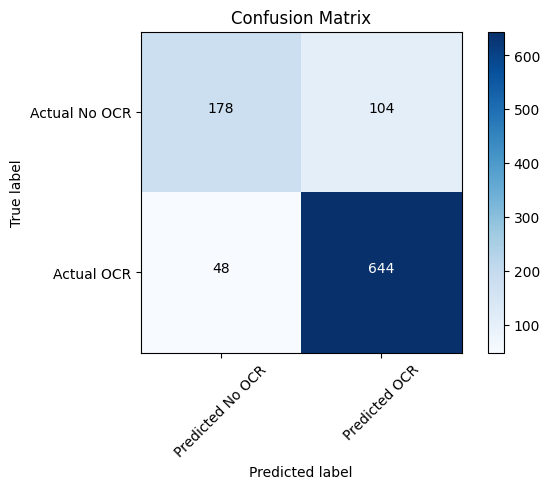

Precision: 0.6312
Recall: 0.7876
Accuracy: 0.8439
F1 Score: 0.7008
Percentage of Correctly Screened Out Images: 18.28%
Percentage of Mistakes (False Negatives): 4.93%


In [13]:
plot_confusion_matrix(pipeline.data)